# ML model predicting NFL season team win totals

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor

## Cleaning the data and feature engineering

Import data from two separate .csv files

In [3]:
Season_data = pd.read_csv('Wins training data 2023.csv', delimiter=';')
DVOA_data = pd.read_csv('NFL DVOA 2010-2021.csv', delimiter=';')

Swap the order of datapoints Seattle and San Francisco in the dataframe DVOA_data as they are in reverse orders in the .csv files

In [4]:
for i in range(len(DVOA_data)):
    if DVOA_data['Team'][i] == 'SF':
        seattle = DVOA_data.iloc[i-1].copy()
        sf = DVOA_data.iloc[i].copy()
        DVOA_data.iloc[i-1] = sf
        DVOA_data.iloc[i] = seattle

Create an array of total wins in a season

In [5]:
Season_record = Season_data['Record'].to_numpy() 
Season_wins = []
for i in range(len(Season_record)):
    if Season_record[i][1] == '-': 
        wins = int(Season_record[i][0])
    else:
        wins = int(str(Season_record[i][0]) + str(Season_record[i][1]))
    Season_wins.append(wins)
Total_season_wins = np.array(Season_wins).astype('float64')

Create an array of DVOA percentages interpreted as positive float values

In [6]:
Total_DVOA = DVOA_data['Total DVOA'].to_numpy() 
for i in range(len(Total_DVOA)):
    Total_DVOA[i] = float(Total_DVOA[i].strip('%').replace(',', '.')) / 10 
min_DVOA = min(Total_DVOA)
for i in range(len(Total_DVOA)):
    Total_DVOA[i] -= min_DVOA

Transform PR and SOS values to positive values

In [7]:
PR_values = Season_data['PR'].replace(',', '.', regex=True).astype(float).tolist()
SOS_values = Season_data['SOS'].replace(',', '.', regex=True).astype(float).tolist()

# Finding the minimum values
min_PR = min(PR_values)
min_SOS = min(SOS_values)

# Subtracting the minimum values from each element in the lists
for i in range(len(PR_values)): 
    PR_values[i] -= min_PR 
    SOS_values[i] -= min_SOS

Calculate total wins for 2021 season as 17 games were played instead of 16

In [8]:
Betting_line = Season_data['W/L O-U'].replace(',', '.', regex=True).to_numpy().astype('float64') 
for i in range(len(Total_season_wins)):
    if i >= 320:
        Total_season_wins[i] = Total_season_wins[i] - Total_season_wins[i] / 17 
        Betting_line[i] = Betting_line[i] - Betting_line[i] / 17

Combine dataframes for the Main_data dataframe

In [9]:
Main_data = pd.DataFrame()
Main_data = Main_data.assign(Wins=Total_season_wins,
                             OU=Betting_line,
                             PR=PR_values,
                             SOS=SOS_values,
                             DVOA=Total_DVOA,
                             EW=DVOA_data['Estimated Wins'].to_numpy())
Main_data = Main_data.replace(',', '.', regex=True)

## Visualizing features to see correlation

Plot the data to compare features' correlations to labels

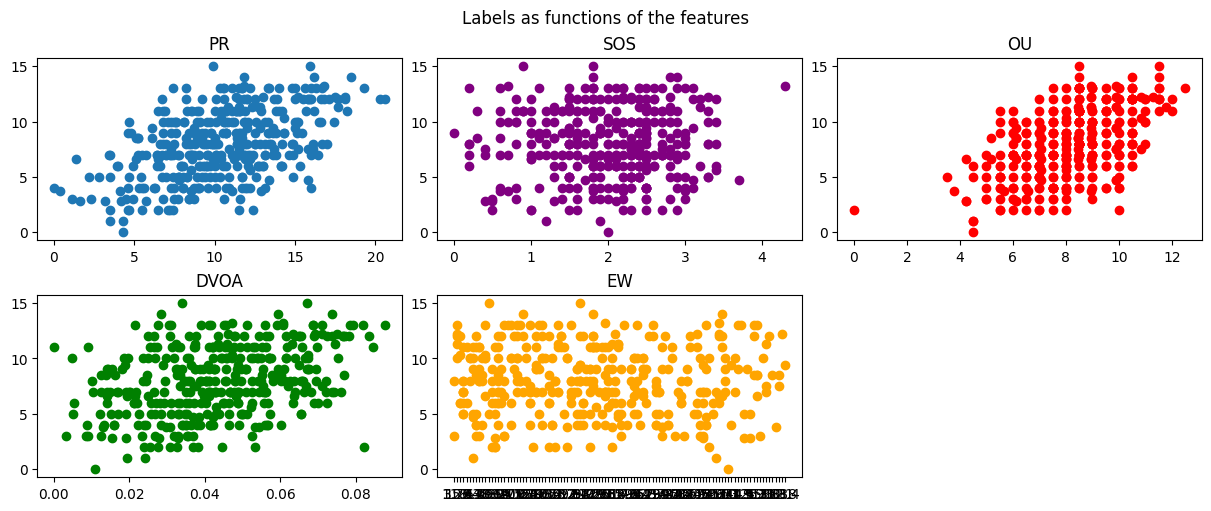

In [10]:
y = Main_data['Wins']
fig, ax = plt.subplots(2, 3, figsize=(12,5), constrained_layout=True) 
fig.suptitle('Labels as functions of the features') 
ax[0,0].scatter(Main_data['PR'], y)
ax[0,0].set_title('PR')
ax[0,1].scatter(Main_data['SOS'], y, color='purple') 
ax[0,1].set_title('SOS')
ax[0,2].scatter(Main_data['OU'],y, color='red')
ax[0,2].set_title('OU')
ax[1,0].scatter(Main_data['DVOA'],y, color='green')
ax[1,0].set_title('DVOA')
ax[1,1].scatter(Main_data['EW'],y, color='orange')
ax[1,1].set_title('EW')
ax[1,2].axis('off')
plt.show()

## Training the linear regression model

Split the data into training, validation and testing sets containing features ‘PR’, ‘SOS’, ‘OU’, ‘DVOA’, ‘EW’ and label ‘Wins’

In [11]:
Features = Main_data.drop(columns=['Wins']).to_numpy().reshape(-1,5)
Labels = Main_data['Wins'].to_numpy()
X, X_val, y, y_val = train_test_split(Features, Labels, test_size=0.20, random_state=28)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=43)

Train and validate the regression model and print the errors

In [12]:
reg = LinearRegression()
reg.fit(X_train, y_train)
y_pred = reg.predict(X_train)
training_error = mean_squared_error(y_train, y_pred)
print('Training error for the linear model: {}'.format(training_error)) 
y_val_pred = reg.predict(X_val)
val_error = mean_squared_error(y_val, y_val_pred)
print('Validation error for the linear model: {}'.format(val_error))

Training error for the linear model: 6.336791275812444
Validation error for the linear model: 7.943325685906032


In [13]:
## Training the MLP model

In [14]:
Find the optimal number of layers and neurons for the neural network. Maximum number of
neurons for the optimization is solved with the equation 𝑁 = h
𝑁𝑠 𝛼∗(𝑁𝑖 +𝑁𝑜 )

SyntaxError: invalid character '∗' (U+2217) (1677683076.py, line 3)

In [15]:
num_layers = list(range(2,6))
max_neurons = int(352 / (3 * (5 + 1))) ## 20 
num_neurons = list(range(5, max_neurons + 1))

In [16]:
training_errors = []
validation_errors = []
for i in range(len(num_layers)):
    for j in range(len(num_neurons)):
        hl_size = tuple([num_neurons[j]]*num_layers[i])
        
        mlp_regr = MLPRegressor(hidden_layer_sizes=hl_size, max_iter=1000, random_state=23)
        mlp_regr.fit(X_train, y_train)

        y_pred_train = mlp_regr.predict(X_train)
        tr_error = mean_squared_error(y_train, y_pred_train)

        y_pred_val = mlp_regr.predict(X_val)
        val_error = mean_squared_error(y_val, y_pred_val)

        training_errors.append(tr_error)
        validation_errors.append(val_error)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Plot the training and validation errors

Training and validation errors:


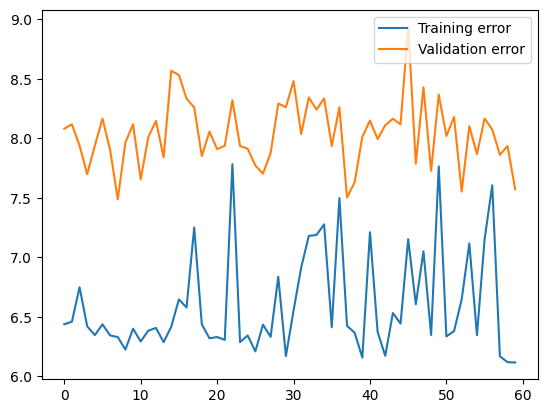

In [17]:
print('Training and validation errors:') 
def plot_errors(y, z):
    x = list(range(len(y)))
    plt.plot(x, y)
    plt.plot(x, z)
    plt.legend(['Training error', 'Validation error'], loc=1)
    plt.show()
plot_errors(training_errors, validation_errors)

Find the point where the sum of training and validation errors is the lowest

Sum of errors:


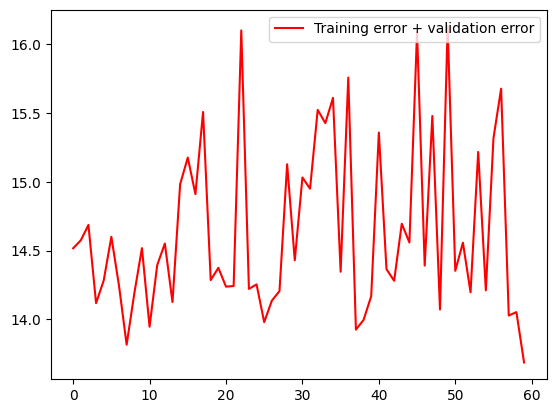

In [18]:
errors = []
for k in range(len(training_errors)):
    errors.append(training_errors[k] + validation_errors[k])
min_index = errors.index(min(errors))
plt.plot(list(range(len(errors))),errors, color='red')
plt.legend(['Training error + validation error'], loc=1)
print('Sum of errors:')

Lowest error is at point 𝑥 = (𝐿𝑎𝑦𝑒𝑟𝑠−2)∗15+𝑁𝑒𝑢𝑟𝑜𝑛𝑠−5 = 54 Solve the counts of layers and neurons

In [19]:
final_neurons = min_index % 15 + 5
final_layers = (min_index - int(final_neurons) + 5) / 15 + 2 
print('Layer count for the model: {}'.format(int(final_layers))) 
print('Neurons per layer: {}'.format(int(final_neurons)))

Layer count for the model: 5
Neurons per layer: 19


Train the MLP model with the optimized layer and neuron counts

In [20]:
hl_list = []
for i in range(0,int(final_layers)):
    hl_list.append(final_neurons)
hl_size = tuple(hl_list)

mlp_regr = MLPRegressor(hidden_layer_sizes=hl_size, max_iter=500, random_state=23)
mlp_regr.fit(X_train, y_train)

y_pred_train_mlp = mlp_regr.predict(X_train)
tr_error_mlp = mean_squared_error(y_train, y_pred_train_mlp)

y_pred_val_mlp = mlp_regr.predict(X_val)
val_error_mlp = mean_squared_error(y_val, y_pred_val_mlp)

print('Training error for the MLP model: {}'.format(tr_error_mlp)) 
print('Validation error for the MLP model: {}'.format(val_error_mlp))

Training error for the MLP model: 6.115995666493144
Validation error for the MLP model: 7.570998307851026


## Testing both models

In [37]:
y_test_pred = reg.predict(X_test)
test_error = mean_squared_error(y_test, y_test_pred)

y_test_pred_mlp = mlp_regr.predict(X_test)
test_error_mlp = mean_squared_error(y_test, y_test_pred_mlp)

print('Test error for the linear model: {}'.format(test_error)) 
print('Test error for the MLP model: {}'.format(test_error_mlp))

Test error for the linear model: 5.764781843717262
Test error for the MLP model: 5.821112133090842


# 2023 predictions

In [38]:
DVOA_2023 = pd.read_csv('2022 DVOA.csv')
wins_2023 = pd.read_csv('NFL 2023 wins PR SOS.csv', delimiter=';')

In [39]:
wins_2023['PR'] = wins_2023['PR'].replace(',', '.', regex=True).astype(float)
wins_2023['SOS'] = wins_2023['SOS'].replace(',', '.', regex=True).astype(float)

DVOA_2023.head(), wins_2023.head()

(  Team  Total DVOA Rank Total DVOA  Prev. Year Rank   W-L  Weighted DVOA Rank  \
 0  ARI               29     -22.4%               10  4-13                  29   
 1  ATL               20      -2.9%               30  7-10                  21   
 2  BAL                7      17.9%               19  10-7                   8   
 3  BUF                1      35.1%                2  13-3                   2   
 4  CAR               28     -14.0%               27  7-10                  23   
 
   Weighted DVOA  Offense DVOA Rank Offense DVOA  Defense DVOA Rank  ...  \
 0        -20.4%                 30       -15.9%                 24  ...   
 1         -4.9%                 13         5.8%                 30  ...   
 2         10.6%                 12         6.6%                  7  ...   
 3         34.9%                  2        19.0%                  4  ...   
 4         -8.8%                 27       -10.0%                 25  ...   
 
   Estimated Wins Rank  Estimated Wins Unadj. To

In [40]:
# Creating a mapping of team abbreviations to their full names based on the provided data and common NFL team abbreviations
team_mapping = {
    "Arizona Cardinals": "ARI",
    "Atlanta Falcons": "ATL",
    "Baltimore Ravens": "BAL",
    "Buffalo Bills": "BUF",
    "Carolina Panthers": "CAR",
    "Chicago Bears": "CHI",
    "Cincinnati Bengals": "CIN",
    "Cleveland Browns": "CLE",
    "Dallas Cowboys": "DAL",
    "Denver Broncos": "DEN",
    "Detroit Lions": "DET",
    "Green Bay Packers": "GB",
    "Houston Texans": "HOU",
    "Indianapolis Colts": "IND",
    "Jacksonville Jaguars": "JAX",
    "Kansas City Chiefs": "KC",
    "Las Vegas Raiders": "LV",
    "Los Angeles Chargers": "LAC",
    "Los Angeles Rams": "LAR",
    "Miami Dolphins": "MIA",
    "Minnesota Vikings": "MIN",
    "New England Patriots": "NE",
    "New Orleans Saints": "NO",
    "New York Giants": "NYG",
    "New York Jets": "NYJ",
    "Philadelphia Eagles": "PHI",
    "Pittsburgh Steelers": "PIT",
    "San Francisco 49ers": "SF",
    "Seattle Seahawks": "SEA",
    "Tampa Bay Buccaneers": "TB",
    "Tennessee Titans": "TEN",
    "Washington Commanders": "WAS"
}

# Replacing full team names with abbreviations in the wins_2023 dataset
wins_2023['Tm'] = wins_2023['Tm'].map(team_mapping)

# Re-merging the datasets
merged_data = pd.merge(wins_2023, DVOA_2023, left_on="Tm", right_on="Team", how="left")

# Selecting the relevant columns to match the structure of the Main_data dataset
prediction_data = merged_data[['W/L O-U', 'PR', 'SOS', 'Total DVOA', 'Estimated Wins']]
prediction_data['Total DVOA'] = prediction_data['Total DVOA'].str.rstrip('%').astype('float')

# Renaming the columns to match the Main_data dataset
prediction_data.columns = ['OU', 'PR', 'SOS', 'DVOA', 'EW']

prediction_data


/var/folders/1c/w5hm02414rld96xtpz54gcyr0000gn/T/ipykernel_14629/3850927101.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_data['Total DVOA'] = prediction_data['Total DVOA'].str.rstrip('%').astype('float')


,OU,PR,SOS,DVOA,EW
0,4.5,-8.5,-0.6,-22.4,4.8
1,8.5,-2.4,-2.7,-2.9,8.2
2,9.5,3.1,0.2,17.9,11.4
3,10.5,6.8,2.4,35.1,14.8
4,7.5,-3.5,-1.7,-14.0,6.5
5,7.5,-2.7,-1.2,-26.6,4.9
6,11.5,5.3,0.8,18.1,11.7
7,9.0,1.0,-0.1,5.3,9.4
8,9.5,4.3,1.1,18.0,11.3
9,8.5,-0.4,0.8,-11.3,7.0


In [44]:
min_PR = min(prediction_data['PR'])
min_SOS = min(prediction_data['SOS'])

# Subtracting the minimum values from each element in the lists
for i in range(len(prediction_data['PR'])): 
    prediction_data['PR'][i] -= min_PR 
    prediction_data['SOS'][i] -= min_SOS

/var/folders/1c/w5hm02414rld96xtpz54gcyr0000gn/T/ipykernel_14629/2843418181.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_data['PR'][i] -= min_PR
/var/folders/1c/w5hm02414rld96xtpz54gcyr0000gn/T/ipykernel_14629/2843418181.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_data['SOS'][i] -= min_SOS
/var/folders/1c/w5hm02414rld96xtpz54gcyr0000gn/T/ipykernel_14629/2843418181.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

In [45]:
prediction_data

,OU,PR,SOS,DVOA,EW
0,4.5,0.0,2.1,-22.4,4.8
1,8.5,6.1,0.0,-2.9,8.2
2,9.5,11.6,2.9,17.9,11.4
3,10.5,15.3,5.1,35.1,14.8
4,7.5,5.0,1.0,-14.0,6.5
5,7.5,5.8,1.5,-26.6,4.9
6,11.5,13.8,3.5,18.1,11.7
7,9.0,9.5,2.6,5.3,9.4
8,9.5,12.8,3.8,18.0,11.3
9,8.5,8.1,3.5,-11.3,7.0


In [41]:
reg_pred_23 = reg.predict(prediction_data)

nn_pred_23 = mlp_regr.predict(prediction_data)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(


In [43]:
nn_pred_23

array([ 7.54410923,  4.50599116,  0.11013117,  0.39150064,  5.56918166,
       11.9496929 ,  0.54801454,  3.19687155,  0.20206049,  5.67994671,
        1.87826818,  3.41543989, 10.867071  , 14.00458534,  5.66022327,
        0.43225355,  4.71627152,  6.97877149,  4.28682163,  1.4293526 ,
        6.86191424,  6.78190247,  5.10969664,  4.83711385,  7.26347416,
        0.18415458,  6.68191914,  0.34674972,  2.46515965,  4.47517933,
        4.11560726,  4.3178771 ])